<a href="https://colab.research.google.com/github/Pragna-Teja-Durishetti/BCStasks/blob/main/AreYouBored.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --quiet ONE-api
!pip install --quiet ibllib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.3/994.3 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 99.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 96.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.8/84.8 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 5.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 76.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.4/109.4 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.0/206.0 kB 13.6 MB/s eta 

In [ ]:
#Data Loading
from one.api import ONE
import numpy as np

ONE.setup(base_url='https://openalyx.internationalbrainlab.org', silent=True)
one = ONE(password='international')

Connected to https://openalyx.internationalbrainlab.org as user "intbrainlab"


In [ ]:
#Subject selection

subjects = one.alyx.rest('subjects', 'list')# Returns a list of dictionaries, each containing subject details
subject = subjects[0]['nickname'] # Takes the first subject from the list and extracts its nickname
sessions = one.alyx.rest('sessions', 'list', subject=subject, task_protocol='biasedChoiceWorld') # Retrieves sessions filtered by subject and task protocol
session_ids = [sess['id'] for sess in sessions[:10]]  # limit to 10 sessions


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from scipy.ndimage import gaussian_filter1d
import seaborn as sns

#  Feature Engineering

all_data = []
for sess_id in session_ids:# Iterates over each session
    try:
        trials = one.load_object(sess_id, 'trials') # Loads trial data for the session
        rt = trials['response_times'] # Time taken to respond in each trial
        iti = trials['intervals'][1:, 0] - trials['intervals'][:-1, 1]  # Time between this trail and the next trial
        n_trials = len(rt) # Total trials in the session
        correct = trials['feedbackType'] == 1 # Boolean mask (1=correct, 0=error)
        perf = pd.Series(correct).rolling(window=20, min_periods=5).mean() # Smoothed performance

        # Data Structuring
        df = pd.DataFrame({
            'session_id': sess_id,
            'reaction_time': rt,
            'iti': np.insert(iti, 0, np.nan),
            'trial_num': np.arange(n_trials),
            'rolling_perf': perf
        })
        all_data.append(df) # append this dataframe to "all_data"
    except Exception as e:
        print(f"Error loading session {sess_id}: {e}")

data = pd.concat(all_data).reset_index(drop=True) # Merges all session DataFrames into one, resetting indices

(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/churchlandlab/Subjects/CSHL_001/2019-08-16/001/alf/_ibl_trials.table.pqt: 100%|██████████| 32.0k/32.0k [00:00<00:00, 135kB/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/churchlandlab/Subjects/CSHL_001/2019-08-15/001/alf/_ibl_trials.table.pqt: 100%|██████████| 39.0k/39.0k [00:00<00:00, 159kB/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/churchlandlab/Subjects/CSHL_001/2019-08-14/009/alf/_ibl_trials.table.pqt: 100%|██████████| 48.1k/48.1k [00:00<00:00, 215kB/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/churchlandlab/Subjects/CSHL_001/2019-08-13/001/alf/_ibl_trials.table.pqt: 100%|██████████| 49.6k/49.6k [00:00<00:00, 220kB/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/churchlandlab/Subjects/CSHL_001/2019-08-12/001/alf/_ibl_trials.table.pqt: 100%|██████████| 43.6k/43.6k [00:00<00:00, 195kB/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/churchland

In [ ]:
#  Boredom Score Definition
# Define boredom score as combination of smoothed RT, ITI, and inverse performance
data['reaction_time_z'] = (data['reaction_time'] - data['reaction_time'].mean()) / data['reaction_time'].std() # Standardizes RT to compare across sessions
data['iti_z'] = (data['iti'] - data['iti'].mean()) / data['iti'].std() # Standardizes ITI
data['inv_perf'] = 1 - data['rolling_perf'] # Converts rolling accuracy (rolling_perf, range 0–1) to error rate (higher = worse performance)
data['boredom_score'] = gaussian_filter1d( # Applies a 1D Gaussian filter (sigma=5) to smooth noise preserving trends
    data[['reaction_time_z', 'iti_z', 'inv_perf']].mean(axis=1).fillna(0), sigma=5 # Combines z-scored RT, z-scored ITI, and inverse performance into a single value per trial and Replaces missing values
)


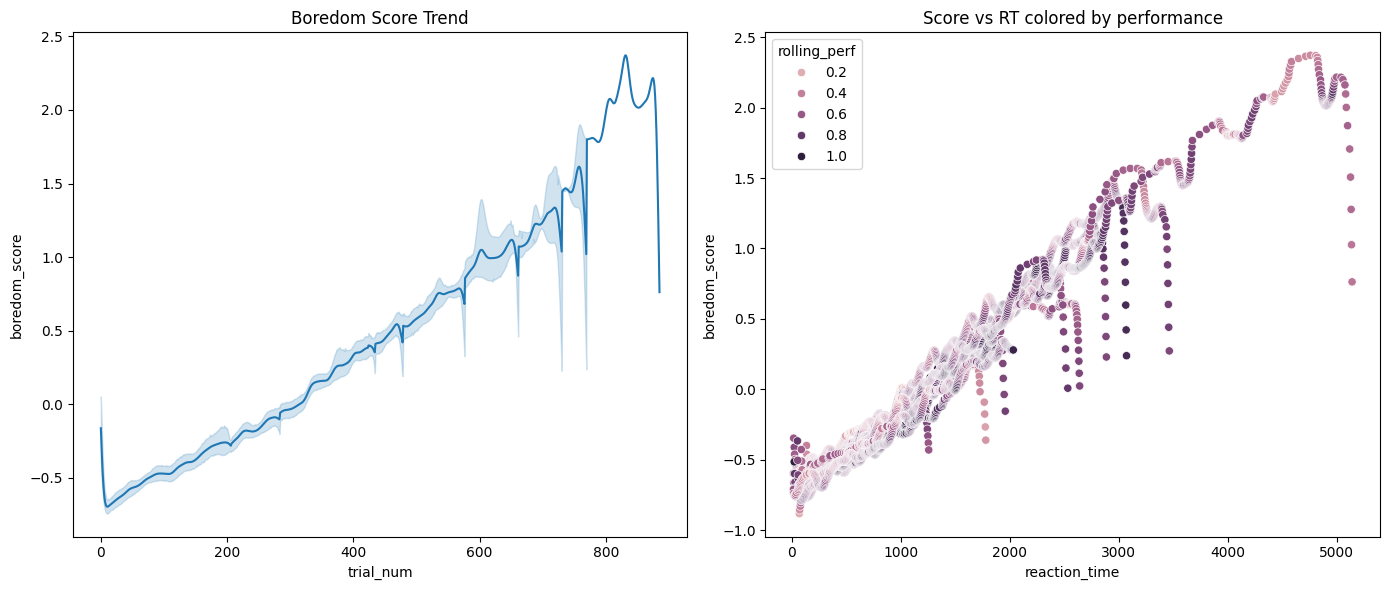

In [ ]:

#  Visualization

plt.figure(figsize=(14, 6))
plt.subplot(121)
sns.lineplot(x='trial_num', y='boredom_score', data=data)
plt.title('Boredom Score Trend')

plt.subplot(122)
sns.scatterplot(x='reaction_time', y='boredom_score', hue='rolling_perf', data=data)
plt.title('Score vs RT colored by performance')
plt.tight_layout()
plt.show()

In [ ]:

# Model Training

features = ['reaction_time', 'iti', 'rolling_perf']
data = data.dropna(subset=features + ['boredom_score'])
X = data[features]
y = data['boredom_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.3)
model = Ridge(alpha=0.5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


MAE of boredom prediction: 0.0653


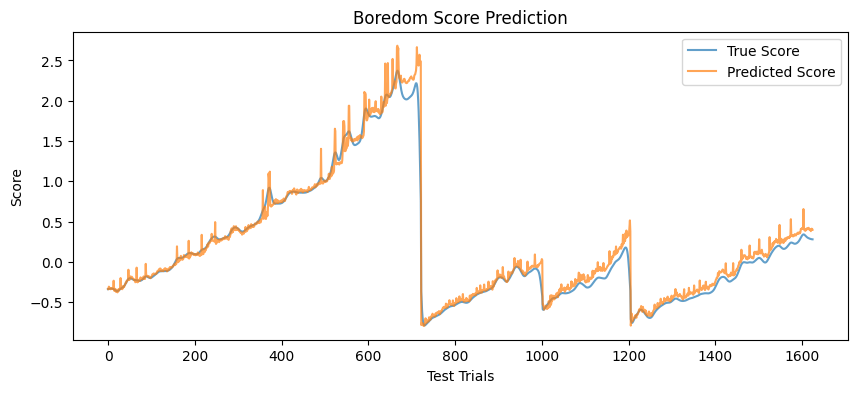

In [ ]:

#  Evaluation

mae = mean_absolute_error(y_test, y_pred)
print(f"MAE of boredom prediction: {mae:.4f}")

plt.figure(figsize=(10, 4))
plt.plot(y_test.values, label='True Score', alpha=0.7)
plt.plot(y_pred, label='Predicted Score', alpha=0.7)
plt.legend()
plt.title('Boredom Score Prediction')
plt.xlabel('Test Trials')
plt.ylabel('Score')
plt.show()
